# 学習型射影勾配法


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/wadayama/MIKA2019/blob/master/ProjectedGradient.ipynb)



## 必要なパッケージのインポート

In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt

## グローバル定数の設定

In [27]:
n = 500 # 信号長
mbs = 100 # ミニバッチサイズ
noise_std = 0.5 # 雑音の標準偏差
alpha = 8.0 # 射影関数のソフトさを表す
A = torch.normal(mean=torch.zeros(n,n), std = 1.0)
max_itr = 10 # 射影勾配法の反復回数
adam_lr = 0.00005 # Adamの学習率

## ミニバッチ生成関数

In [28]:
def gen_minibatch():
    x = 1.0 - 2.0 * torch.randint(0, 2, (mbs, n)).float()
    w = torch.normal(mean=torch.zeros(mbs, n), std = noise_std)
    y = torch.mm(x, A.t()) + w
    return x, y

## 学習型射影勾配法 TPG クラス (Trainable Projected Gradient)

In [29]:
class TPG(nn.Module):
    def __init__(self):
        super(TPG, self).__init__()
        self.beta = nn.Parameter(0.01*torch.ones(max_itr)) # 学習可能ステップサイズパラメータ
    def forward(self, y, num_itr):
        s = torch.zeros(mbs, n) # 初期探索点
        for i in range(num_itr):
            r = s + self.beta[i] * torch.mm(y - torch.mm(s, A.t()), A) # 勾配ステップ
            s = torch.tanh(alpha * r) # 射影ステップ
        return s

## 訓練ループ(インクリメンタルトレーニング）

In [30]:
model = TPG()
opt   = optim.Adam(model.parameters(), lr=adam_lr)
loss_func = nn.MSELoss()
for gen in range(max_itr):
    for i in range(100):
        x, y = gen_minibatch()
        opt.zero_grad()
        x_hat = model(y, gen + 1)
        loss  = loss_func(x_hat, x)
        loss.backward()
        opt.step()
    print(gen, loss.item())

0 0.6082950234413147
1 0.24391546845436096
2 0.07139378041028976
3 0.006003633141517639
4 0.00015484490722883493
5 1.6384794434998184e-05
6 8.442122326722534e-13
7 1.4901195511882181e-12
8 0.007808743976056576
9 6.569952529389411e-05


## 学習しない射影勾配法

In [31]:
class PG(nn.Module): # 普通の射影勾配法
    def __init__(self):
        super(PG, self).__init__()
    def forward(self, y, num_itr, gamma):
        s = torch.zeros(mbs, n) # 初期探索点
        for i in range(num_itr):
            r = s + gamma * torch.mm(y - torch.mm(s, A.t()), A)  # 勾配ステップ　
            s = torch.tanh(alpha * r) # 射影ステップ
        return s
pg_model = PG()

## 誤差のプロット

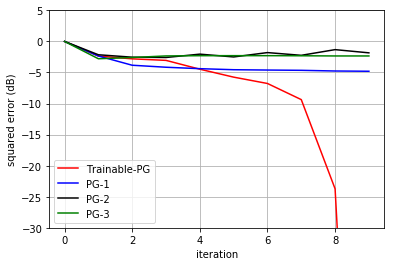

In [32]:
mbs = 1
x, y = gen_minibatch()

norm_list = []
itr_list = []

with torch.no_grad():
    for i in range(max_itr):
        err = (torch.norm(x - model(y, i))**2).item()/n
        norm_list.append(10.0*math.log10(err))
        itr_list.append(i)
plt.plot(itr_list, norm_list, color="red", label="Trainable-PG")

norm_list = []
itr_list = []

for i in range(max_itr):
    err = (torch.norm(x - pg_model(y, i, 0.0010))**2).item()/n
    norm_list.append(10.0*math.log10(err))
    itr_list.append(i)
plt.plot(itr_list, norm_list, color="blue", label="PG-1")

norm_list = []
itr_list = []
for i in range(max_itr):
    err = (torch.norm(x - pg_model(y, i, 0.0015))**2).item()/n
    norm_list.append(10.*math.log10(err))
    itr_list.append(i)
plt.plot(itr_list, norm_list, color="black", label="PG-2")

norm_list = []
itr_list = []
for i in range(max_itr):
    err = (torch.norm(x - pg_model(y, i, 0.0005))**2).item()/n
    norm_list.append(10.0*math.log10(err))
    itr_list.append(i)
plt.plot(itr_list, norm_list, color="green", label="PG-3")

plt.grid()
plt.xlabel("iteration")
plt.ylabel("squared error (dB)")
plt.legend()
plt.ylim([-30, 5])
plt.show()

In [33]:
print('beta = ', model.beta)

beta =  Parameter containing:
tensor([0.0010, 0.0007, 0.0008, 0.0013, 0.0015, 0.0028, 0.0007, 0.0013, 0.0019,
        0.0025], requires_grad=True)
